<a href="https://colab.research.google.com/github/orlandoalexander/Moda-Personal-Assistant/blob/playground/Matthias_category_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import cluster
import random
import time
from io import BytesIO
from keras.layers import Input
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from tqdm.notebook import tqdm

In [ ]:
! pip install git+https://github.com/orlandoalexander/Moda-Personal-Assistant.git@preproc_package

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/MyDrive/Colab Notebooks/Data Moda/images.zip' 

In [ ]:
PATH = '/content/images'

In [ ]:
from preproc.preprocess import AttributePreproc, SectionPreproc, CategoryPreproc

In [ ]:
prep = CategoryPreproc(PATH, (224,224), 0.2)

In [ ]:
X_train, X_test, y_train, y_test, names  = prep.run()

Augmenting category 'Tees'...
Augmenting category 'Dresses'...
Augmenting category 'Blouses'...
Augmenting category 'Sweaters'...
Augmenting category 'Shorts'...
Augmenting category 'Rompers'...
Augmenting category 'Pants'...
Augmenting category 'Jackets'...
Augmenting category 'Skirts'...
Augmenting category 'Cardigans'...
Augmenting category 'Graphic_Tees'...
Augmenting category 'Joggers'...
Augmenting category 'Shirts'...
Augmenting category 'Baggy_Pants'...
Augmenting category 'Suiting'...
Done!


In [ ]:
names

['Baggy_Pants',
 'Blouses',
 'Cardigans',
 'Dresses',
 'Graphic_Tees',
 'Jackets',
 'Joggers',
 'Pants',
 'Rompers',
 'Shirts',
 'Shorts',
 'Skirts',
 'Suiting',
 'Sweaters',
 'Tees']

In [ ]:
y_train[9643]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

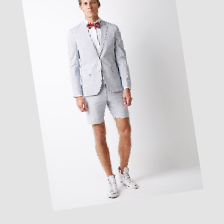

In [ ]:
from PIL import Image
im = Image.fromarray(X_train[9643])
im

In [ ]:
y_train.shape

(9645, 15)

In [ ]:
X_train.shape

(9644, 224, 224, 3)

# Category Classifier Model RESNET 50

In [ ]:
# Training image size --> (224,224,3)
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers
from keras import optimizers
from keras.callbacks import EarlyStopping
#from keras.layers.experimental.preprocessing import Rescaling

In [ ]:
from keras.applications import ResNet50V2

def load_model():
    
    # $CHALLENGIFY_BEGIN
    
    model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(224,224,3))
    
    # $CHALLENGIFY_END
    
    return model

In [ ]:
model = load_model()
model.summary()

In [ ]:
def set_nontrainable_layers(model):
    
    # $CHALLENGIFY_BEGIN
    # Set the first layers to be untrainable
    model.trainable = False
    
    # $CHALLENGIFY_END
    
    return model

In [ ]:
model = set_nontrainable_layers(model)
model.summary()

In [ ]:
from keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    # $CHALLENGIFY_BEGIN
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(15, activation='softmax')
    
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    # $CHALLENGIFY_END
    return model

In [ ]:
model = add_last_layers(model)
model.summary()

In [ ]:
from keras import optimizers
from keras.metrics import Precision, Recall

def build_model():
    # $CHALLENGIFY_BEGIN    
    model = load_model()
    model = add_last_layers(model)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
                  #metrics=[Precision(), Recall()])
    return model
    # $CHALLENGIFY_END

In [ ]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 500)               50176500  
                                                                 
 dense_7 (Dense)             (None, 15)                7515      
                                                                 
Total params: 73,748,815
Trainable params: 50,184,015
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping 

model = build_model()

es = EarlyStopping(monitor = 'val_accuracy', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history1 = model.fit(X_train, y_train,
               epochs=100, 
               batch_size = 64,
               callbacks=[es], 
               validation_split=0.2)

Epoch 1/100


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
121/121 [==============================] - ETA: 0s - loss: 1985.9827 - accuracy: 0.2896

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
121/121 [==============================] - 29s 220ms/step - loss: 1985.9827 - accuracy: 0.2896 - val_loss: 13348.8389 - val_accuracy: 0.0000e+00
Epoch 2/100
121/121 [==============================] - 25s 211ms/step - loss: 378.2444 - accuracy: 0.4241 - val_loss: 11201.3662 - val_accuracy: 0.0000e+00
Epoch 3/100
 16/121 [==>...........................] - ETA: 18s - loss: 273.6264 - accuracy: 0.4824

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(X_test, y_test)

76/76 [==============================] - 6s 85ms/step - loss: 1678.9500 - accuracy: 0.1767


[1678.949951171875, 0.17669017612934113]

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
plot_history(history1)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f146c5866d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f146c5930d0>)

ImportError: ignored

<Figure size 864x288 with 2 Axes>

In [ ]:
res_res = model.evaluate(X_test, y_test)

test_accuracy_res = res_res[-1]


print(f"test_accuracy_res = {round(test_accuracy_res,2)*100} %")


76/76 [==============================] - 8s 93ms/step - loss: 1541.1973 - accuracy: 0.1842
test_accuracy_res = 18.0 %


# Model - VGG19 model

In [ ]:
from keras.applications import VGG19

def load_model():
    
    # $CHALLENGIFY_BEGIN
    
    model = VGG19(weights="imagenet", include_top=False, input_shape=(224,224,3))
    
    # $CHALLENGIFY_END
    
    return model

In [ ]:
model = load_model()
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras.backend import dropout
from keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    # $CHALLENGIFY_BEGIN
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(1024, activation='relu')
    dropout_layer = layers.Dropout(0.5)
    dense_layer2 = layers.Dense(1024, activation='relu')
    prediction_layer = layers.Dense(15, activation='softmax')
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        dropout_layer,
        dense_layer2,
        prediction_layer
    ])
    # $CHALLENGIFY_END
    return model

In [ ]:
model = add_last_layers(model)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_16 (Dense)            (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_18 (Dense)            (None, 15)                15375     
                                                                 
Total params: 46,780,495
Trainable params: 26,756,111


In [ ]:
from keras import optimizers
from keras.metrics import Precision, Recall

def build_model():
    # $CHALLENGIFY_BEGIN    
    model = load_model()
    model = add_last_layers(model)
    
    opt = optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
                  #metrics=[Precision(), Recall()])
    return model
    # $CHALLENGIFY_END

In [ ]:
model = build_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0         
                                                                 
 dense_19 (Dense)            (None, 1024)              25691136  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_20 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_21 (Dense)            (None, 15)                15375     
                                                                 
Total params: 46,780,495
Trainable params: 26,756,111


In [ ]:
from keras.callbacks import EarlyStopping 

model = build_model()

es = EarlyStopping(monitor = 'val_accuracy', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history1 = model.fit(X_train, y_train,
               epochs=10, 
               batch_size = 32,
               callbacks=[es], 
               validation_split=0.2)

Epoch 1/10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
242/242 [==============================] - ETA: 0s - loss: 7.6159 - accuracy: 0.2223

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
242/242 [==============================] - 64s 249ms/step - loss: 7.6159 - accuracy: 0.2223 - val_loss: 2.2949 - val_accuracy: 0.2411
Epoch 2/10
242/242 [==============================] - 58s 240ms/step - loss: 2.6697 - accuracy: 0.2499 - val_loss: 2.3117 - val_accuracy: 0.2364
Epoch 3/10
242/242 [==============================] - 58s 241ms/step - loss: 2.8261 - accuracy: 0.2552 - val_loss: 2.2719 - val_accuracy: 0.2426
Epoch 5/10
242/242 [==============================] - 58s 239ms/step - loss: 2.8906 - accuracy: 0.2543 - val_loss: 2.3288 - val_accuracy: 0.2348
Epoch 6/10
242/242 [==============================] - 58s 239ms/step - loss: 2.6507 - ac

In [ ]:
model.evaluate(X_test, y_test)

76/76 [==============================] - 15s 202ms/step - loss: 2.3621 - accuracy: 0.2410


[2.362133264541626, 0.24097885191440582]

In [ ]:
model.save('test_model.tf')

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7efde937a4c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7efde937a4c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
